## Skin Low Resolution Color Image Modeling 

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(42)
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

%matplotlib inline

Using TensorFlow backend.


### Reading in the MetaData and Image Files

In [3]:
skin = pd.read_csv('../../datasets/HAM10000_metadata.csv')

Low Resolution Images provide the features

In [4]:
skin_8by8 = pd.read_csv('../../datasets/hmnist_8_8_RGB.csv')#low res images

Dropping label column(not part of original data) as only pixel data is needed

In [5]:
skin_8by8.drop('label',axis=1, inplace=True)

Joining metadata together with image data to create one DataFrame 192 pixel columns and 7 data columns

In [6]:
skin =pd.concat([skin,skin_8by8],axis = 1)

In [7]:
skin.shape

(10015, 199)

Target Distribution

In [8]:
skin['dx'].value_counts(normalize=True)

nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: dx, dtype: float64

The two diagnoses I want to focus on are melanoma, 11.1% of the total and basal cell carcinoma, 5.1% of the total. To avoid unbalanced classes, take a random sample of the remaining , noncancer diagnosis purposefully not undersampling the 'nv' which is the most challenging to discern from melanoma as well as the largest portion of diagnoses 66.9%.There are 1627 cancer rows, a random sampling of 1627 noncancer rows will be selected.

In [9]:
malignant=skin[(skin['dx']=='mel')| (skin['dx']=='bcc')]
malignant.shape

(1627, 199)

The noncancerous diagnoses are grouped together in the benign subset.

In [10]:
benign= skin[(skin['dx']=='df')|(skin['dx']=='nv')|(skin['dx']=='bkl')|(skin['dx']=='vasc')|(skin['dx']=='akiec')]
benign.shape

(8388, 199)

Shuffling all the rows of the benign diagnosis

In [11]:
benign = benign.sample(benign.shape[0], replace = True)
benign.shape

(8388, 199)

For modeling the malignant diagnosis are converted to ones.

In [12]:
malignant['dx'] =1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [13]:
malignant['dx'].value_counts()

1    1627
Name: dx, dtype: int64

For modeling the noncancerous diagnoses are converted to zeroes

In [14]:
benign['dx']=0

In [15]:
benign['dx'].value_counts()

0    8388
Name: dx, dtype: int64

Malignant and a subset of benign are joined together to become skin_equal

In [16]:
skin_equal = pd.concat((malignant,benign.head(1627)))

In [17]:
skin_equal.shape

(3254, 199)

The image_id is unique to each row, it is set as the index

In [18]:
skin_equal.set_index('image_id', inplace = True)

In [19]:
skin_equal.head()

,lesion_id,dx,dx_type,age,sex,localization,pixel0000,pixel0001,pixel0002,pixel0003,...,pixel0182,pixel0183,pixel0184,pixel0185,pixel0186,pixel0187,pixel0188,pixel0189,pixel0190,pixel0191
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0025964,HAM_0000871,1,histo,40.0,female,chest,169,143,150,185,...,201,207,183,195,199,171,183,166,138,143
ISIC_0030623,HAM_0000871,1,histo,40.0,female,chest,203,176,192,206,...,206,211,181,205,210,185,207,211,189,206
ISIC_0027190,HAM_0000040,1,histo,80.0,male,upper extremity,148,127,148,161,...,190,168,151,176,161,148,173,149,134,158
ISIC_0031023,HAM_0005678,1,histo,60.0,male,chest,116,92,107,202,...,219,229,212,224,240,227,241,147,131,149
ISIC_0028086,HAM_0005678,1,histo,60.0,male,chest,227,207,229,225,...,248,241,236,241,247,240,247,242,232,243


In [20]:
X = skin_equal.drop(columns=['lesion_id','dx','dx_type',
                    'age', 'sex','localization'])

In [21]:
X.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel0182,pixel0183,pixel0184,pixel0185,pixel0186,pixel0187,pixel0188,pixel0189,pixel0190,pixel0191
image_id,,,,,,,,,,,,,,,,,,,,,
ISIC_0025964,169,143,150,185,155,169,199,171,185,204,...,201,207,183,195,199,171,183,166,138,143
ISIC_0030623,203,176,192,206,177,197,209,183,199,209,...,206,211,181,205,210,185,207,211,189,206
ISIC_0027190,148,127,148,161,143,165,167,148,169,171,...,190,168,151,176,161,148,173,149,134,158
ISIC_0031023,116,92,107,202,176,199,217,197,220,233,...,219,229,212,224,240,227,241,147,131,149
ISIC_0028086,227,207,229,225,206,225,248,241,255,198,...,248,241,236,241,247,240,247,242,232,243


In [22]:
y= skin_equal[['dx']]

In [23]:
y.shape

(3254, 1)

Train Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


Making sure to have correct type

In [25]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

Changing to numpy array

In [26]:
X_train=X_train.values
X_test=X_test.values

Looking at X_train shape

In [27]:
X_train.shape

(2440, 192)

In [28]:
y_train.shape

(2440, 1)

Looking at X_train first entry

In [29]:
X_train[0]

array([178., 136., 134., 179., 127., 121., 200., 157., 158., 210., 174.,
       180., 212., 181., 188., 206., 171., 177., 198., 162., 169., 178.,
       137., 141., 184., 141., 135., 182., 129., 122., 201., 158., 160.,
       216., 184., 192., 213., 177., 185., 208., 169., 175., 205., 171.,
       176., 190., 151., 154., 188., 144., 139., 194., 148., 146., 211.,
       179., 191., 219., 188., 200., 217., 182., 189., 212., 175., 185.,
       205., 167., 174., 190., 150., 153., 197., 163., 164., 202., 163.,
       162., 206., 166., 170., 209., 169., 183., 215., 175., 187., 209.,
       166., 173., 206., 168., 177., 189., 145., 148., 199., 167., 168.,
       208., 173., 177., 199., 151., 151., 189., 130., 127., 199., 145.,
       149., 212., 174., 182., 204., 165., 173., 188., 143., 145., 192.,
       153., 153., 204., 166., 168., 203., 159., 161., 189., 132., 129.,
       186., 126., 125., 203., 161., 170., 198., 158., 166., 183., 139.,
       142., 188., 149., 148., 196., 154., 154., 20

In [30]:
# This scales each value to be between 0 and 1. 
X_train/=255
X_test/=255

In [31]:
# Reshape each image to be 8 x 8 x 3.
X_train = X_train.reshape(X_train.shape[0],8,8,3) 
X_test = X_test.reshape(X_test.shape[0],8,8,3) 
# Reshaping your images is often one of the most difficult
# aspects of machine learning with image data.

Checking shape of X_train and y_train now

In [32]:
X_train.shape

(2440, 8, 8, 3)

In [33]:
y_train.shape

(2440, 1)

### Model Construction

Starting with Feed Forward Neural Network

In [34]:
model = Sequential()

model.add(Flatten(input_shape=(8, 8, 3)))

model.add(Dense(128, input_shape=(8, 8, 3), activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(X_train,
                    y_train, 
                    batch_size=256,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 0s 133us/step - loss: 0.6791 - acc: 0.5693 - val_loss: 0.6599 - val_acc: 0.6069
Epoch 2/20
2440/2440 [==============================] - 0s 17us/step - loss: 0.6466 - acc: 0.6275 - val_loss: 0.6492 - val_acc: 0.6671
Epoch 3/20
2440/2440 [==============================] - 0s 19us/step - loss: 0.6414 - acc: 0.6258 - val_loss: 0.6366 - val_acc: 0.5934
Epoch 4/20
2440/2440 [==============================] - 0s 19us/step - loss: 0.6216 - acc: 0.6533 - val_loss: 0.6292 - val_acc: 0.6106
Epoch 5/20
2440/2440 [==============================] - 0s 19us/step - loss: 0.6218 - acc: 0.6414 - val_loss: 0.6250 - val_acc: 0.6437
Epoch 6/20
2440/2440 [==============================] - 0s 20us/step - loss: 0.6167 - acc: 0.6500 - val_loss: 0.6620 - val_acc: 0.5344
Epoch 7/20
2440/2440 [

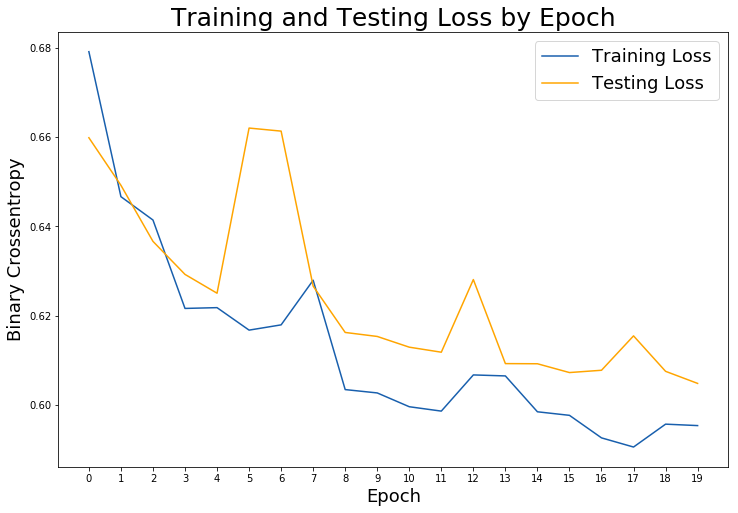

In [35]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

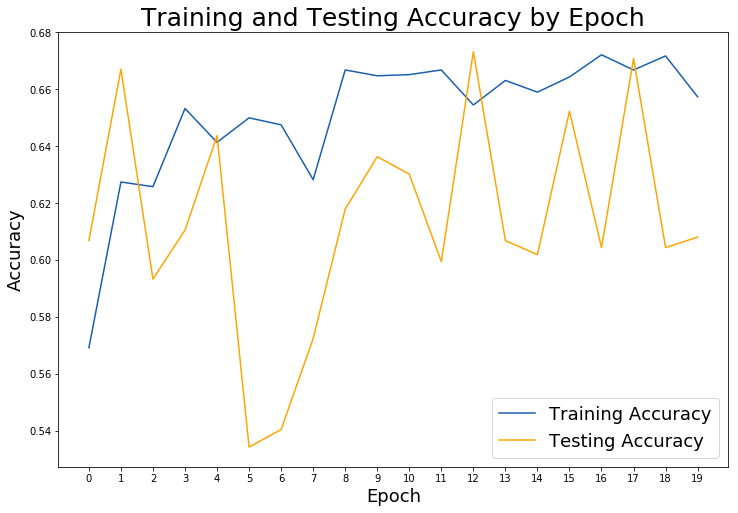

In [36]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [37]:
# Evaluate model on test data.
score = model.evaluate(X_test, y_test, verbose=0)
labels = model.metrics_names

# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

model.summary()

loss: 0.6048014852280112
acc: 0.6081081081081081
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 28,865
Trainable params: 28,865
Non-trainable params: 0
_________________________________________________________________


Constructing Convolutional Neural Network

In [38]:
# Instantiate a CNN.
cnn_model = Sequential()

# Add a convolutional layer.

cnn_model.add(Conv2D(filters = 6,     # number of filters
                     kernel_size = 3, # height/width of filter
                     activation = 'relu', # activation function 
                     input_shape = (8, 8, 3))) # shape of input (image)

# dimensions of region of pooling
cnn_model.add(MaxPooling2D(pool_size=(2,2))) 

cnn_model.add(Conv2D(16,
                     kernel_size = 3,
                     activation='relu'))

cnn_model.add(Flatten())

# Add a densely-connected layer with 128 neurons.
cnn_model.add(Dense(128, activation='relu'))

# Add a final layer with 1 neuron.
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Fit model on training data
history = cnn_model.fit(X_train,
              y_train,
              batch_size=256,
              validation_data=(X_test, y_test),          
              epochs=20,
              verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 0s 188us/step - loss: 0.6916 - acc: 0.5131 - val_loss: 0.6888 - val_acc: 0.6253
Epoch 2/20
2440/2440 [==============================] - 0s 38us/step - loss: 0.6888 - acc: 0.5467 - val_loss: 0.6850 - val_acc: 0.6290
Epoch 3/20
2440/2440 [==============================] - 0s 35us/step - loss: 0.6824 - acc: 0.6447 - val_loss: 0.6793 - val_acc: 0.6511
Epoch 4/20
2440/2440 [==============================] - 0s 29us/step - loss: 0.6748 - acc: 0.6598 - val_loss: 0.6713 - val_acc: 0.6007
Epoch 5/20
2440/2440 [==============================] - 0s 40us/step - loss: 0.6640 - acc: 0.6307 - val_loss: 0.6633 - val_acc: 0.6585
Epoch 6/20
2440/2440 [==============================] - 0s 37us/step - loss: 0.6532 - acc: 0.6225 - val_loss: 0.6557 - val_acc: 0.6646
Epoch 7/20
2440/2440 [==============================] - 0s 38us/step - loss: 0.6456 - acc: 0.6250 - val_loss: 0.6554 - val_acc: 0.6658
Epoch 8

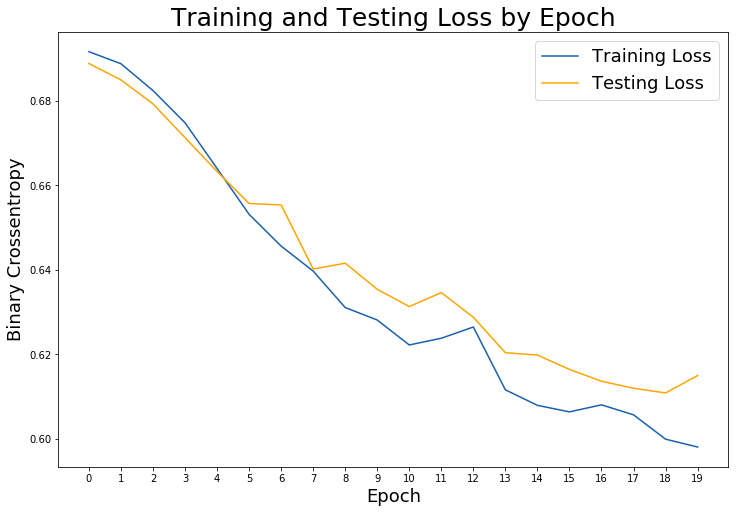

In [39]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

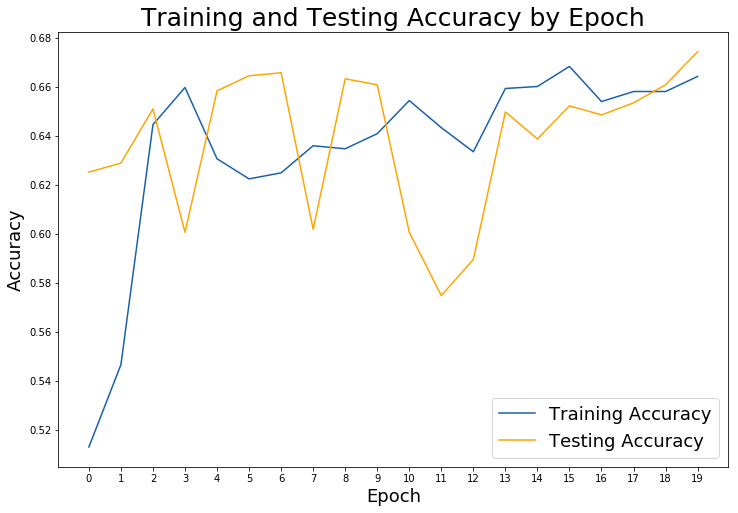

In [40]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [41]:
cnn_model.summary()

# Evaluate model on test data
cnn_score = cnn_model.evaluate(X_test, y_test, verbose=0)
cnn_labels = cnn_model.metrics_names

# Compare CNN and FFNN models.
print(f'CNN {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 6, 6, 6)           168       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 6)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 16)          880       
_________________________________________________________________
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 3,353
Trainable params: 3,353
Non-trainable params: 0
_________________________________________________________________
CNN loss

#### Building a second convolutional model

In [42]:
# Instantiate a CNN.
cnn_model_2 = Sequential()

# Add a convolutional layer.
cnn_model_2.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(8,8,3))) # shape of input (image)

# Add a pooling layer.
cnn_model_2.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling



# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_2.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_2.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(0.5))

# Add a densely-connected layer with 16 neurons.
cnn_model_2.add(Dense(16, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_2.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_2.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_2.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
# Fit model on training data
cnn_model_2.fit(X_train,
                y_train,
                batch_size=128,
                validation_data=(X_test, y_test),
                epochs=20,
                verbose=1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 1s 247us/step - loss: 0.7128 - acc: 0.4930 - val_loss: 0.6897 - val_acc: 0.5061
Epoch 2/20
2440/2440 [==============================] - 0s 54us/step - loss: 0.6894 - acc: 0.5254 - val_loss: 0.6882 - val_acc: 0.5455
Epoch 3/20
2440/2440 [==============================] - 0s 48us/step - loss: 0.6824 - acc: 0.5734 - val_loss: 0.6729 - val_acc: 0.6560
Epoch 4/20
2440/2440 [==============================] - 0s 46us/step - loss: 0.6666 - acc: 0.5951 - val_loss: 0.6514 - val_acc: 0.6265
Epoch 5/20
2440/2440 [==============================] - 0s 50us/step - loss: 0.6544 - acc: 0.6078 - val_loss: 0.6399 - val_acc: 0.6585
Epoch 6/20
2440/2440 [==============================] - 0s 50us/step - loss: 0.6364 - acc: 0.6275 - val_loss: 0.6266 - val_acc: 0.6314
Epoch 7/20
2440/2440 [=====

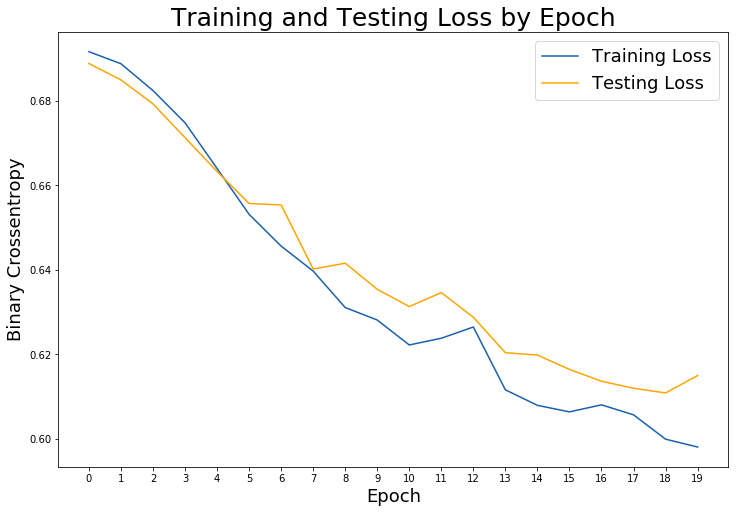

In [43]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

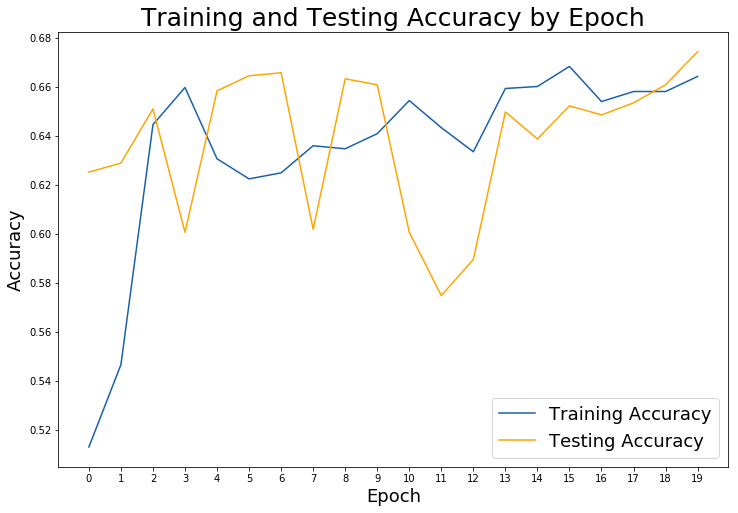

In [44]:
# Check out our train loss and test loss over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [45]:
# Evaluate model on test data
cnn_2_score = cnn_model_2.evaluate(X_test, y_test, verbose=0)
cnn_2_labels = cnn_model_2.metrics_names

# Compare models.
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

cnn_model_2.summary()

CNN 2 loss  : 0.5742021864989466
CNN 2 acc   : 0.6891891890427404

CNN 1 loss  : 0.6149953476334087
CNN 1 acc   : 0.6744471748865207

FFNN loss : 0.6048014852280112
FFNN acc  : 0.6081081081081081
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 6, 6, 16)          448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 144)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                9280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Den

#### Building a third convolutional model

In [46]:
# Instantiate a CNN.
cnn_model_3 = Sequential()

# Add a convolutional layer.
cnn_model_3.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(8,8,3))) # shape of input (image)

# Add a pooling layer.
cnn_model_3.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling


# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_3.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_3.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_3.add(Dropout(0.5))

# Add a densely-connected layer with 32 neurons.
cnn_model_3.add(Dense(32, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_3.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_3.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_3.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

# Fit model on training data
history = cnn_model_3.fit(X_train,
                          y_train,
                          batch_size=128,
                          validation_data=(X_test, y_test),
                          epochs=20,
                          verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 1s 270us/step - loss: 0.7066 - acc: 0.5238 - val_loss: 0.6888 - val_acc: 0.5762
Epoch 2/20
2440/2440 [==============================] - 0s 51us/step - loss: 0.6923 - acc: 0.5213 - val_loss: 0.6863 - val_acc: 0.5221
Epoch 3/20
2440/2440 [==============================] - 0s 45us/step - loss: 0.6848 - acc: 0.5373 - val_loss: 0.6759 - val_acc: 0.6290
Epoch 4/20
2440/2440 [==============================] - 0s 47us/step - loss: 0.6712 - acc: 0.6020 - val_loss: 0.6583 - val_acc: 0.6204
Epoch 5/20
2440/2440 [==============================] - 0s 49us/step - loss: 0.6593 - acc: 0.6180 - val_loss: 0.6460 - val_acc: 0.6622
Epoch 6/20
2440/2440 [==============================] - 0s 54us/step - loss: 0.6462 - acc: 0.6242 - val_loss: 0.6369 - val_acc: 0.6683
Epoch 7/20
2440/2440 [==============================] - 0s 54us/step - loss: 0.6312 - acc: 0.6512 - val_loss: 0.6165 - val_acc: 0.6400
Epoch 8

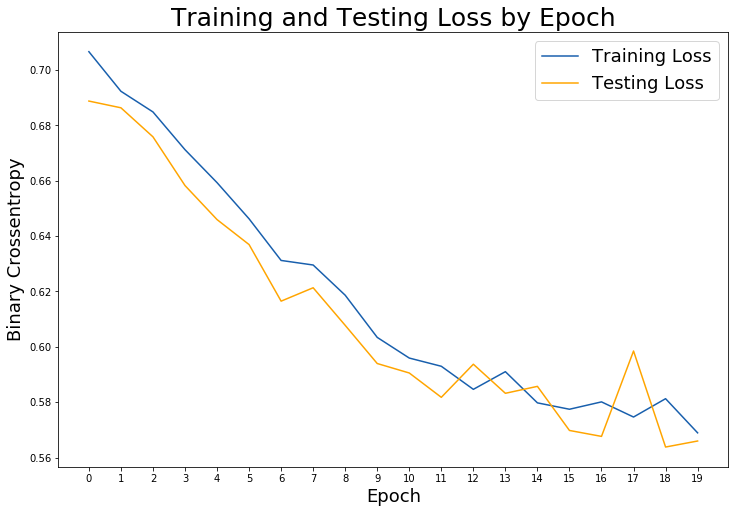

In [47]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

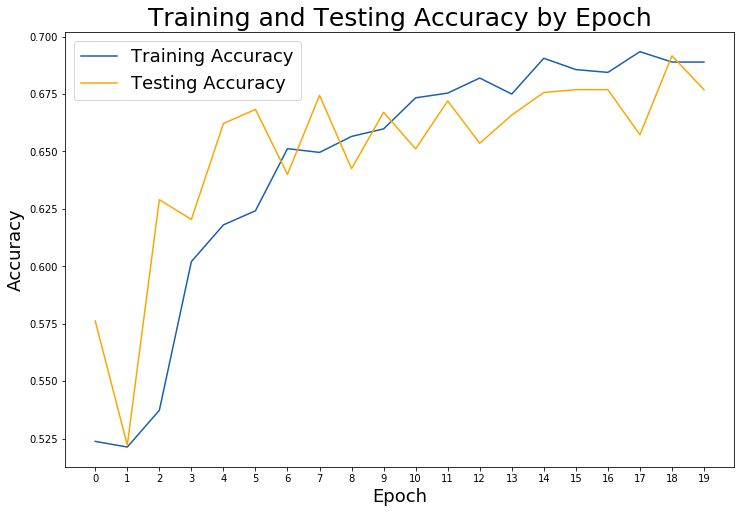

In [48]:
# Check out our train accuracy and test accuracy over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [49]:
# Evaluate model on test data.
cnn_3_score = cnn_model_3.evaluate(X_test,
                                   y_test,
                                   verbose=1)

cnn_3_labels = cnn_model_3.metrics_names

# Compare models.
print(f'CNN 3 {cnn_3_labels[0]}  : {cnn_3_score[0]}')
print(f'CNN 3 {cnn_3_labels[1]}   : {cnn_3_score[1]}')
print()
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

814/814 [==============================] - 0s 44us/step
CNN 3 loss  : 0.5659848688861369
CNN 3 acc   : 0.6769041767577282

CNN 2 loss  : 0.5742021864989466
CNN 2 acc   : 0.6891891890427404

CNN 1 loss  : 0.6149953476334087
CNN 1 acc   : 0.6744471748865207

FFNN loss : 0.6048014852280112
FFNN acc  : 0.6081081081081081


### Fourth Convolutional Model

In [50]:
# Instantiate a CNN.
cnn_model_4 = Sequential()

# Add a convolutional layer.
cnn_model_4.add(Conv2D(filters = 16,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu',      # activation function 
                     input_shape=(8,8,3))) # shape of input (image)
cnn_model_4.add(Conv2D(filters = 32,         # number of filters
                     kernel_size = 3,        # height/width of filter
                     activation='relu'))      # activation function 
                     
# Add a pooling layer.
cnn_model_4.add(MaxPooling2D(pool_size=(2,2))) # dimensions of region of pooling
# Let's try to avoid overfitting!
cnn_model_4.add(Dropout(0.3))


# We have to remember to flatten to go from the "box" to the vertical line of nodes!
cnn_model_4.add(Flatten())

# Add a densely-connected layer with 64 neurons.
cnn_model_4.add(Dense(64, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_4.add(Dropout(0.5))

# Add a densely-connected layer with 32 neurons.
cnn_model_4.add(Dense(48, activation='relu'))

# Let's try to avoid overfitting!
cnn_model_4.add(Dropout(0.5))

# Add a final layer with 1 neuron.
cnn_model_4.add(Dense(1, activation='sigmoid'))

# Compile model
cnn_model_4.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

# Fit model on training data
history = cnn_model_4.fit(X_train,
                          y_train,
                          batch_size=128,
                          validation_data=(X_test, y_test),
                          epochs=20,
                          verbose=1)

Train on 2440 samples, validate on 814 samples
Epoch 1/20
2440/2440 [==============================] - 1s 358us/step - loss: 0.6961 - acc: 0.5127 - val_loss: 0.6899 - val_acc: 0.5049
Epoch 2/20
2440/2440 [==============================] - 0s 73us/step - loss: 0.6933 - acc: 0.5082 - val_loss: 0.6857 - val_acc: 0.6155
Epoch 3/20
2440/2440 [==============================] - 0s 72us/step - loss: 0.6870 - acc: 0.5475 - val_loss: 0.6775 - val_acc: 0.5909
Epoch 4/20
2440/2440 [==============================] - 0s 70us/step - loss: 0.6723 - acc: 0.5770 - val_loss: 0.6549 - val_acc: 0.6130
Epoch 5/20
2440/2440 [==============================] - 0s 71us/step - loss: 0.6496 - acc: 0.6098 - val_loss: 0.6313 - val_acc: 0.6192
Epoch 6/20
2440/2440 [==============================] - 0s 70us/step - loss: 0.6329 - acc: 0.6246 - val_loss: 0.6250 - val_acc: 0.6241
Epoch 7/20
2440/2440 [==============================] - 0s 70us/step - loss: 0.6171 - acc: 0.6512 - val_loss: 0.6104 - val_acc: 0.6450
Epoch 8

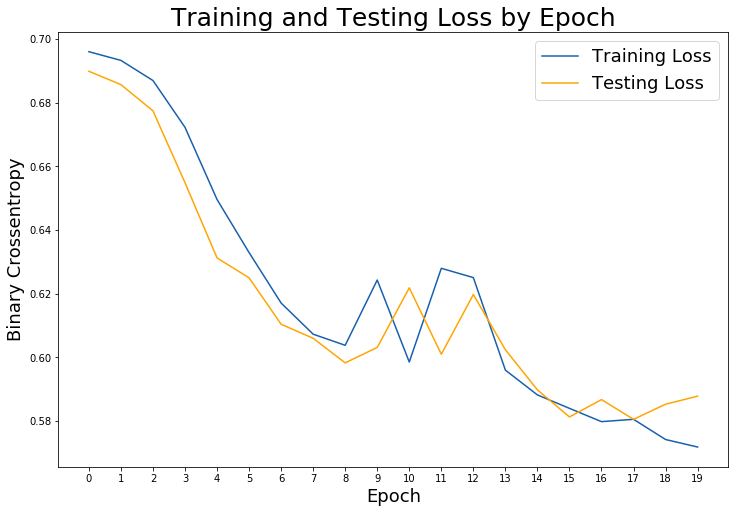

In [51]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Binary Crossentropy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

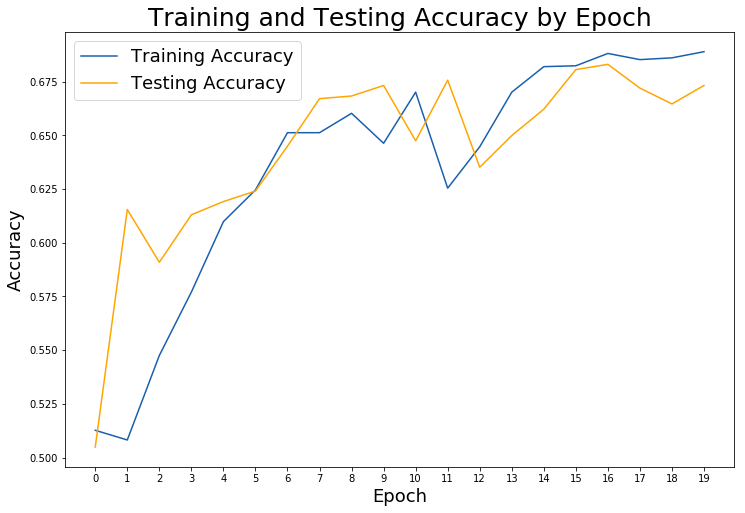

In [52]:
# Check out our train accuracy and test accuracy over epochs.
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(test_accuracy, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10,11,12,13,14,15,16,17,18,19])

plt.legend(fontsize = 18);

In [53]:
# Evaluate model on test data.
cnn_4_score = cnn_model_4.evaluate(X_test,
                                   y_test,
                                   verbose=1)

cnn_4_labels = cnn_model_4.metrics_names

# Compare models.
print(f'CNN 4 {cnn_4_labels[0]}  : {cnn_4_score[0]}')
print(f'CNN 4 {cnn_4_labels[1]}   : {cnn_4_score[1]}')
print()
print(f'CNN 3 {cnn_3_labels[0]}  : {cnn_3_score[0]}')
print(f'CNN 3 {cnn_3_labels[1]}   : {cnn_3_score[1]}')
print()
print(f'CNN 2 {cnn_2_labels[0]}  : {cnn_2_score[0]}')
print(f'CNN 2 {cnn_2_labels[1]}   : {cnn_2_score[1]}')
print()
print(f'CNN 1 {cnn_labels[0]}  : {cnn_score[0]}')
print(f'CNN 1 {cnn_labels[1]}   : {cnn_score[1]}')
print()
print(f'FFNN {labels[0]} : {score[0]}')
print(f'FFNN {labels[1]}  : {score[1]}')

814/814 [==============================] - 0s 62us/step
CNN 4 loss  : 0.5878144322507798
CNN 4 acc   : 0.6732186730722245

CNN 3 loss  : 0.5659848688861369
CNN 3 acc   : 0.6769041767577282

CNN 2 loss  : 0.5742021864989466
CNN 2 acc   : 0.6891891890427404

CNN 1 loss  : 0.6149953476334087
CNN 1 acc   : 0.6744471748865207

FFNN loss : 0.6048014852280112
FFNN acc  : 0.6081081081081081
